# Regression Module Project: Estimating Zillow Home Value

### Project Scenario:
You are a junior data scientist on the __Zillow data science team__ and recieve the following email in your inbox:

__We want to be able to predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017.__

We have a model already, but we are hoping your insights can help us improve it. __I need recommendations on a way to make a better model.__ Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

(One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. Because property taxes are assessed at the county level, we would like to know what states and counties these are located in).

-- The Zillow Data Science Team



## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from acquire import get_zillow
from prepare import prepare_zillow

from scipy import stats
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering, scaled_data, assessed_value_regression_plot


## Acquire prepped and split data

#### - Moving forward, train data will be used to prevent data leakage

In [2]:
train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


In [3]:
# Examine split integrity
print(f'\n\tTrain Shape: {train.shape}\n\n\tValidate Shape: {validate.shape}\n\n\tTest Shape: {test.shape}' )


	Train Shape: (29297, 8)

	Validate Shape: (12557, 8)

	Test Shape: (10464, 8)


## Initial Data Explolatory Analysis

In [4]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,year_built,fips,trans_date,trans_month
16035,3.0,2.0,1522.0,64360.0,1925.0,6037.0,2017-04-14,4
44800,2.0,1.0,900.0,338073.0,1951.0,6037.0,2017-08-10,8
20047,2.0,1.0,807.0,51727.0,1951.0,6037.0,2017-04-21,4
5077,3.0,3.0,2458.0,653996.0,1985.0,6059.0,2017-02-16,2
36597,3.0,2.0,1386.0,242779.0,1962.0,6037.0,2017-06-30,6


In [5]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])



In [6]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037


## Map locations with National Data

In [7]:
# Map fits with national data  
# (Source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

# Get unique locations
location = train.zip_code.unique()
location

array([6037, 6059, 6111])

### Create new columns with names of city

In [8]:
train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})

train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


In [9]:
# from uszipcode import SearchEngine, SimpleZipcode, Zipcode

# search = SearchEngine()

# def zco(x):
#     city = search.by_zipcode(x).major_city
#     return city if city else 'None'

# train['metro'] = train['zipcode'].apply(zco)

In [10]:
# Describe the data

train.describe()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code
count,29297.000000,29297.000000,29297.000000,2.929700e+04,29297.000000,29297.000000,29297.000000,29297.000000
mean,3.311773,2.303137,1922.911561,5.258636e+05,5.051712,16.478479,1963.286821,6049.144861
std,0.933666,1.012818,987.408513,7.157899e+05,2.347439,8.964306,23.128629,21.030609
min,0.000000,0.000000,152.000000,9.242000e+03,1.000000,1.000000,1878.000000,6037.000000
25%,3.000000,2.000000,1270.000000,1.933730e+05,3.000000,9.000000,1950.000000,6037.000000
50%,3.000000,2.000000,1664.000000,3.724420e+05,5.000000,16.000000,1961.000000,6037.000000
75%,4.000000,3.000000,2312.000000,6.190000e+05,7.000000,24.000000,1979.000000,6059.000000
max,12.000000,11.000000,21929.000000,2.434570e+07,9.000000,31.000000,2016.000000,6111.000000


In [11]:
# Get data summary information
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29297 entries, 16035 to 39200
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed_count       29297 non-null  float64
 1   bath_count      29297 non-null  float64
 2   square_feet     29297 non-null  float64
 3   assessed_value  29297 non-null  float64
 4   trans_month     29297 non-null  int64  
 5   trans_day       29297 non-null  int64  
 6   built_year      29297 non-null  int64  
 7   zip_code        29297 non-null  int64  
 8   city            29297 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 2.2+ MB


In [12]:
# Check for null values
train.isnull().sum()

bed_count         0
bath_count        0
square_feet       0
assessed_value    0
trans_month       0
trans_day         0
built_year        0
zip_code          0
city              0
dtype: int64

In [13]:
# Any null columns?
train.columns.isnull().any()

False

In [14]:
# Value counts
train.value_counts()

bed_count  bath_count  square_feet  assessed_value  trans_month  trans_day  built_year  zip_code  city       
3.0        2.0         1050.0       259334.0        5            25         1960        6037      Los Angeles    2
0.0        0.0         400.0        49627.0         5            1          1950        6037      Los Angeles    1
4.0        2.0         1576.0       82375.0         5            1          1952        6037      Los Angeles    1
                       1578.0       397610.0        5            2          1978        6111      Ventura        1
                                    96458.0         6            16         1959        6037      Los Angeles    1
                                                                                                                ..
3.0        2.0         1337.0       109332.0        6            1          1953        6037      Los Angeles    1
                       1336.0       965007.0        1            26         1946     

## Data Scalling

### Standart scaler Choosen: (Result will have a mean of 0 and a standard deviation of 1)


In [15]:
# # # Create a scaler object
# # scaler = sklearn.preprocessing.StandardScaler()

# # # Fit on train subset
# # scaler.fit(train)

#  # Transform scaler to train, validate and test subsets
# train_scaled = scaler.transform(train)
# validate_scaled = scaler.transform(validate)
# test_scaled = scaler.transform(test)

# plt.figure(figsize=(13, 6))
# plt.subplot(121)
# plt.hist(train, bins=25, ec='black')
# plt.title('Original')
# plt.subplot(122)
# plt.hist(train_scaled, bins=25, ec='black')
# plt.title('Scaled')

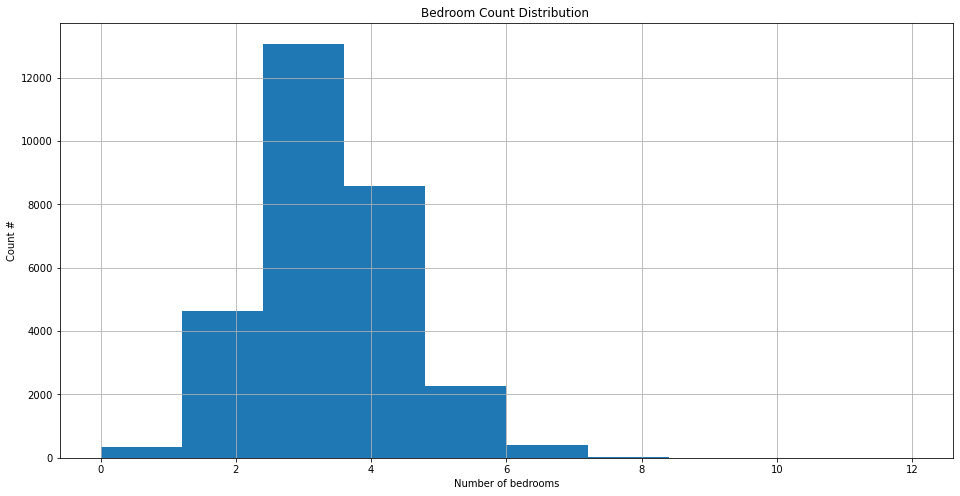

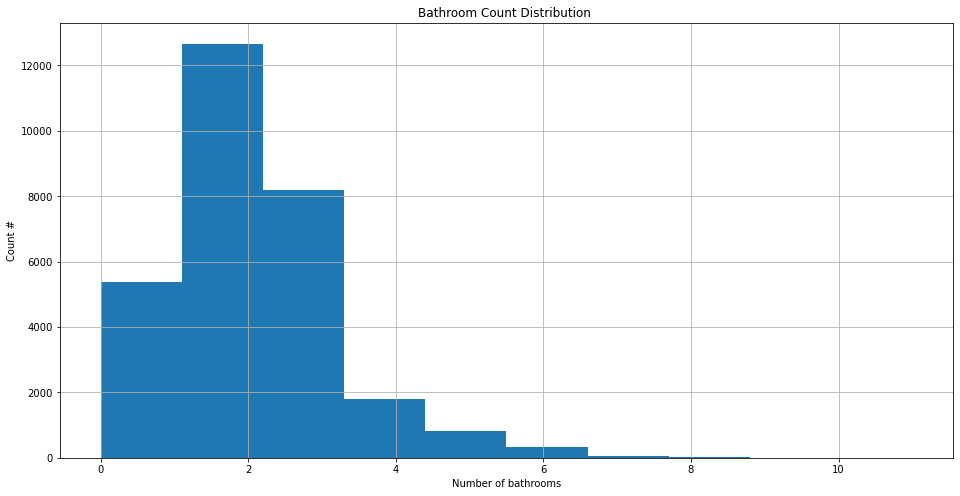

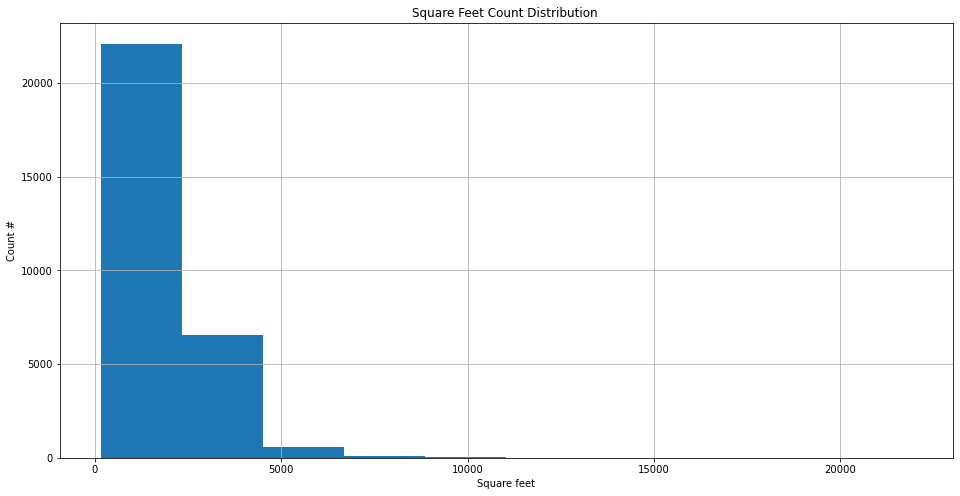

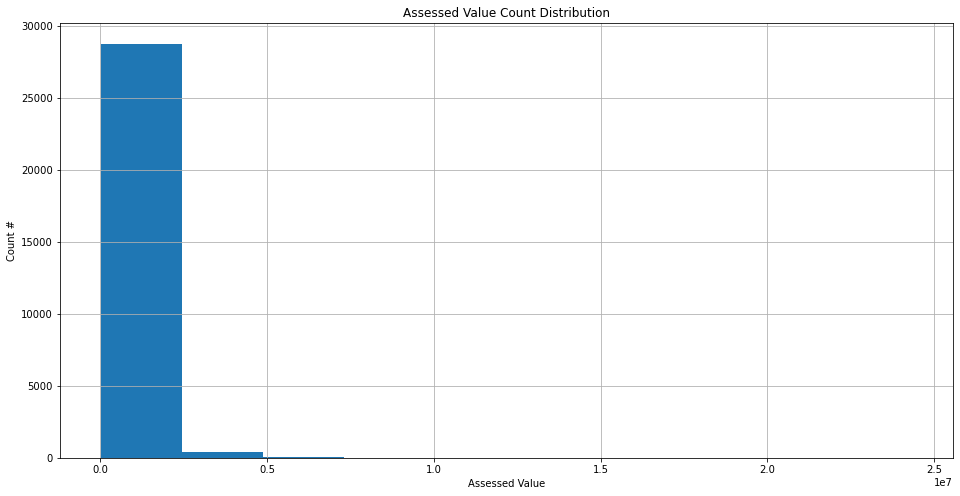

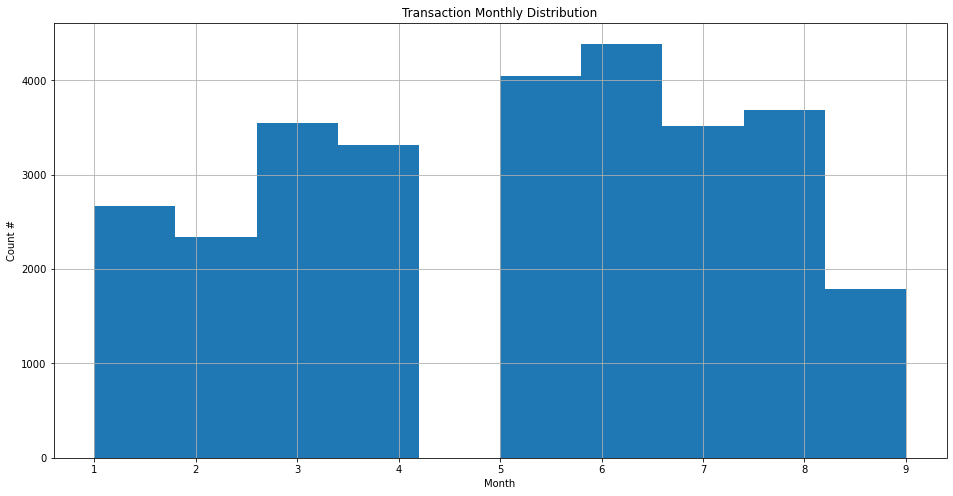

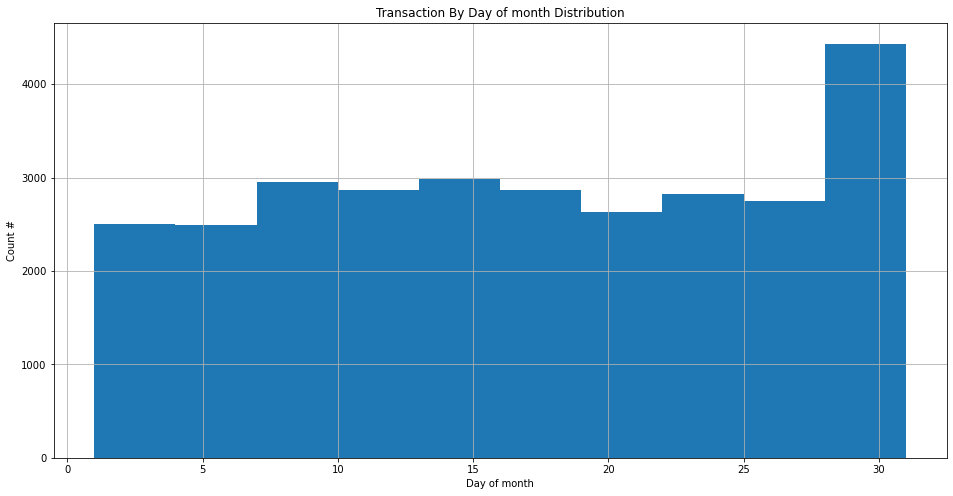

In [16]:
# Initial Visualizations
plt.figure(figsize = (16, 8))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Square Feet Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Assessed Value Count Distribution')
plt.ylabel('Count #')
plt.xlabel('Assessed Value')
train.assessed_value.hist()
plt.show()

plt.figure(figsize = (16, 8))
plt.title('Transaction Monthly Distribution')
plt.ylabel('Count #')
plt.xlabel('Month')
train.trans_month.hist()
plt.show()
plt.figure(figsize = (16, 8))
plt.title('Transaction By Day of month Distribution')
plt.ylabel('Count #')
plt.xlabel('Day of month')
train.trans_day.hist()
plt.show()

In [17]:
train.head()

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city
16035,3.0,2.0,1522.0,64360.0,4,14,1925,6037,Los Angeles
44800,2.0,1.0,900.0,338073.0,8,10,1951,6037,Los Angeles
20047,2.0,1.0,807.0,51727.0,4,21,1951,6037,Los Angeles
5077,3.0,3.0,2458.0,653996.0,2,16,1985,6059,Orange
36597,3.0,2.0,1386.0,242779.0,6,30,1962,6037,Los Angeles


## Key Findings:
### __NOTE:_ All homes in dataset are zillow homes of 2017
- 3 bedroom and 2 baths are the most common household classifications in 2017
- Less than 2400 square feet single familly household were the most preferable homes in 2017
- Homes built in late 1940s to early 1960s were the most transactioned homes in 2017. About 9500 homes. Followed by homes built in early 1960s to mid 1970s accounting approximately 5800, then third were homes in late 1970s to 1990s.
- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s.
- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
- Most transactions were average throughout the year but peaked towards the last few days of teh year. 


## Initial possible drivers for home value:

- Homes with __square feet greater than 2000__ are more likely to be bougth and sold than those below that value
- Homes with bedroom count between __3 and 4__ are more likely to generate more assessed value than other homes.
- The more the __batrooms (over 3) a home has__, the likely the rise in assessed value. 
- Homes __built after the year 2000__ are more likely to have higher assessed home value than those built before that year.
- Homes in __Los Angels__ are likely to be highly assessed due to size of city than those in Orange and Ventura


# Exploration Phase:

## Hypothesis Formulation & Testing

### Hypothesis I:  Test Square feet VS assessed values (One sample T-Test)

In [18]:
# Get subset of home with square feet over 2000 feet
homes_value_over_2000_sqr_feet = train[train.square_feet > 2000].assessed_value
overall_home_value = train.assessed_value.mean()

H0 = 'Assessed value for homes with over 2000 square feet = the assessed value for all homes'
H1 = 'Assessed value for homes with over 2000 square feet > than the assessed value for all homes'

# Set confidence level to 0.05
alpha = 0.05

t, p = stats.ttest_1samp(homes_value_over_2000_sqr_feet, overall_home_value )

print(f'\n\tT-Value: {t} \n\tP-Value: {p/2} \n\tAlpha : {alpha}')



	T-Value: 33.68731896609945 
	P-Value: 2.6123960407430466e-236 
	Alpha : 0.05


>#### Evaluate the results (One sample t-test)


In [19]:

if p/2 > alpha:
    
    print(f'We fail to reject:- {H0}')
    
elif t < 0:
    
    print(f'Failed to reject:- {H0}')
    
else:
    
    print(f'\n\tREJECT:- {H0}\n')
    
    print(f'\n\tCONCLUSION:- {H1}\n')




	REJECT:- Assessed value for homes with over 2000 square feet = the assessed value for all homes


	CONCLUSION:- Assessed value for homes with over 2000 square feet > than the assessed value for all homes



## Hypothesis II: Bed Count 3 & 4  VS  Others Assessed Value (Independent/ Two Sample T-Test)

In [20]:
# Check bed count selections

list(train.bed_count.unique())

[3.0, 2.0, 4.0, 5.0, 7.0, 1.0, 6.0, 12.0, 9.0, 0.0, 8.0, 10.0]

In [21]:
H0 = 'Mean assessed value for homes with bedroom count between  3 and 4 = mean assessed value for homes with bedroom count between not 3 and 4'
H1 = 'Mean assessed value for homes with bedroom count between  3 and 4 > mean assessed value for homes with bedroom count between not 3 and 4'

# Set aplha level
alpha = 0.05

# Create subset
bed_count_3_4_assessed_val = train[(train.bed_count >= 2 ) & (train.bed_count <= 4)].assessed_value
bed_count_not_3_4_assessed_val = train[(train.bed_count != 2 ) & (train.bed_count != 4)].assessed_value

# Variance not equal
print(f'3 & 4 BR var: {bed_count_3_4_assessed_val.var()}|| Not 3 & 4 BR var:{bed_count_not_3_4_assessed_val.var()}')

print('Not equal var')

t, p = stats.ttest_ind(bed_count_3_4_assessed_val, bed_count_not_3_4_assessed_val, equal_var=False)
t, p / 2


print(f'\n\tT-Value: {t} \n\tP-Value: {p/2} \n\tAlpha : {alpha}')

3 & 4 BR var: 274472069401.30576|| Not 3 & 4 BR var:654359487459.4808
Not equal var

	T-Value: -9.283539547269042 
	P-Value: 8.857345245783746e-21 
	Alpha : 0.05


>#### Evaluate the two sample t-test


In [22]:

if p/2 > alpha:
    
    print(f'\n\tFAILED TO REJECT:- {H0}\n')
    print(f'\n\tCONCLUSION:- {H0}\n') 
elif t < 0:
    
    print(f'\n\tFAILED TO REJECT:- {H0}\n') 
    print(f'\n\tCONCLUSION:- {H0}\n')
else:
    
    print(f'\n\tREJECT:- {H0}\n')
    print(f'\n\tCONCLUSION:- {H1}\n')


	FAILED TO REJECT:- Mean assessed value for homes with bedroom count between  3 and 4 = mean assessed value for homes with bedroom count between not 3 and 4


	CONCLUSION:- Mean assessed value for homes with bedroom count between  3 and 4 = mean assessed value for homes with bedroom count between not 3 and 4



## Hypothesis III: [Bathroom Count <  3] VS [Bathroom Count >3 & < 5] VS [Bathroom Count > 5] Assessed Value (ANOVA Test)

In [23]:
# Get selections of bathroom counts

train.bath_count.unique()

array([ 2. ,  1. ,  3. ,  5. ,  1.5,  4. ,  4.5,  6. ,  2.5,  3.5,  5.5,
        8. ,  6.5,  7. ,  9. ,  0. , 11. ,  7.5,  8.5, 10. ])

In [24]:
# Formulated hypothesis
H0 = 'The assessed value for homes with less than 3 bathrooms compares equally with those with > 3 but < 5  and those > 5'
H1 = 'The assessed value for homes with less than 3 bathrooms do not eaqual those with > 3 but < 5  and those > 5'

# Set alpha value
alpha = 0.05

# Create subsets means
mean_assessed_val_baths_3_and_less = train[train.bath_count < 3].assessed_value
mean_assessed_val_baths_above3_and_less_than5 = train[(train.bath_count >= 3) & (train.bath_count < 5)].assessed_value
mean_assessed_val_baths_above5 = train[(train.bath_count > 5)].assessed_value

# Unequal vars
print('Variance less than 3 Baths:',mean_assessed_val_baths_3_and_less.var())
print('Variance 3 but less than 5 Baths:',mean_assessed_val_baths_above3_and_less_than5.var())
print('Variance over 5 Baths:',mean_assessed_val_baths_above5.var())

# Calculate the ANOVA
f, p = stats.f_oneway(mean_assessed_val_baths_3_and_less, 
                      mean_assessed_val_baths_above3_and_less_than5, 
                      mean_assessed_val_baths_above5)
f, p

Variance less than 3 Baths: 112067649550.51057
Variance 3 but less than 5 Baths: 448330476238.4225
Variance over 5 Baths: 8030334816325.969


(4946.390094328267, 0.0)

>#### Evaluate the ANOVA Test

In [25]:
if p < alpha:
    
    print(f'REJECT HYPOTHESIS: {H0}')
    
else:
    print('FAILED TO REJECT HYPOTHESIS: {H0}')

REJECT HYPOTHESIS: The assessed value for homes with less than 3 bathrooms compares equally with those with > 3 but < 5  and those > 5


## Hypothesis IV:  Build year >= 2000 assessed value VS build year < 2000 assessed value (Independent/ two sample t-test)

In [26]:
# Get unique built years
train.built_year.unique()

array([1925, 1951, 1985, 1962, 1950, 1952, 1955, 1963, 1975, 1976, 1926,
       1974, 1937, 1948, 1982, 2000, 1957, 1959, 1961, 1964, 1947, 1972,
       1953, 1913, 1998, 1965, 1973, 1954, 1943, 1956, 1949, 1996, 1999,
       1977, 1938, 1924, 1941, 1933, 1945, 1968, 1981, 1960, 1923, 1979,
       1942, 1929, 1936, 1922, 2007, 1940, 1989, 1934, 2002, 2004, 1997,
       1946, 1990, 1970, 1971, 1969, 1980, 1992, 1967, 1978, 2001, 1988,
       1928, 1984, 1991, 1930, 1987, 1958, 2003, 1935, 2011, 2006, 2014,
       1927, 1986, 1904, 2012, 2005, 1994, 2010, 1920, 1944, 1939, 1983,
       1914, 1905, 1966, 1995, 2013, 2008, 1921, 1880, 1916, 1932, 1912,
       1918, 1931, 1993, 2009, 1906, 1885, 1910, 1919, 2015, 1911, 1915,
       1882, 2016, 1917, 1909, 1895, 1908, 1901, 1902, 1907, 1896, 1903,
       1890, 1887, 1900, 1898, 1892, 1878, 1888, 1893])

In [27]:
H0 = 'Assessed value for homes built after the year 2000 are = to assessed value for homes built before year 2000'
H1 = 'Assessed value for homes built after the year 2000 are != to assessed value for homes built before year 2000'

# Set alpha level

alpha = 0.05

# Create the subsets
assessed_val_built_year_over_2000 = train[train.built_year >= 2000].assessed_value
assessed_val_built_year_less_than_2000 = train[train.built_year < 2000].assessed_value

# Check Variance
print(f'Assessed value variance for homes built after year 2000: {assessed_val_built_year_over_2000.var()}')
print(f'Assessed value variance for homes built before year 2000: {assessed_val_built_year_less_than_2000.var()}')


# Compute t & p values
t, p = stats.ttest_ind(assessed_val_built_year_over_2000, assessed_val_built_year_less_than_2000, equal_var=False)
t, p / 2


Assessed value variance for homes built after year 2000: 1317085761948.1047
Assessed value variance for homes built before year 2000: 416521385374.57495


(21.584885726175482, 1.5046419764218285e-95)

>#### Evaluate results 

In [28]:
if p / 2 > alpha:
    
    print(f'FAILED TO REJECT HYPOTHESIS:- {H0}')
elif t < 0:
    print(f'FAILED TO REJECT HYPOTHESIS:- {H0}')
else:
    print(f'REJECT HYPOTHESIS:- {H0}')


REJECT HYPOTHESIS:- Assessed value for homes built after the year 2000 are = to assessed value for homes built before year 2000


## Hypothesis V: ANOVA test home vales by locations

In [29]:
# - Homes in Los Angels are likely to be highly assessed due to size of city than those in Orange and Ventura

# H0 = 'The assessed home value based of the three locations are all equal'

# Feature Engineering (SelectKBest, RFE)

>#### Finding features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [30]:
train.columns

Index(['bed_count', 'bath_count', 'square_feet', 'assessed_value',
       'trans_month', 'trans_day', 'built_year', 'zip_code', 'city'],
      dtype='object')

In [31]:
# Select features to explore 

X_train = train[['bed_count', 'bath_count', 'square_feet',
                 'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet', 
                       'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet', 
               'trans_month', 'trans_day', 'built_year', 'zip_code']]
y_test = test.assessed_value

## SelectKBest

In [32]:
select_k_best = select_kbest_feature_engineering(X_train, y_train, 3)
select_k_best

Enter count of SelectKBest features to return: 3


Index(['bed_count', 'bath_count', 'square_feet'], dtype='object')

>### Rank SelectKBest Features

In [33]:
kbest = SelectKBest(f_regression, k = 2)

kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7fc2c9160e50>)

In [34]:
kbest_results = pd.DataFrame(dict(p = kbest.pvalues_, 
                                  f = kbest.scores_), 
                             index = X_train.columns)
kbest_results

,p,f
bed_count,0.000000e+00,2375.005194
bath_count,0.000000e+00,10153.362041
square_feet,0.000000e+00,16422.875486
trans_month,9.875797e-02,2.725661
trans_day,6.599920e-04,11.601159
built_year,2.183660e-208,964.559699
zip_code,3.179239e-05,17.312943


In [35]:

X_train_transformed = pd.DataFrame(kbest.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[kbest.get_support()])

X_train_transformed.head()


,bath_count,square_feet
16035,2.0,1522.0
44800,1.0,900.0
20047,1.0,807.0
5077,3.0,2458.0
36597,2.0,1386.0


## Recursive Feature Elimination (RFE)

In [36]:
rfe_feature_engineering(X_train, y_train, 3)

Enter count of RFE features to return: 3


Index(['bed_count', 'bath_count', 'built_year'], dtype='object')

>### Rank RFE Features

In [37]:
# Call linear reg'
model = LinearRegression()

# Fit the model and select best two features (n_features_to_select = 2)
rfe = RFE(model, n_features_to_select = 2)
rfe.fit(X_train, y_train)

# Rank the RFE features
pd.DataFrame({'rfe_ranks': rfe.ranking_}, index = X_train.columns)

,rfe_ranks
bed_count,1
bath_count,1
square_feet,5
trans_month,4
trans_day,3
built_year,2
zip_code,6


In [38]:
# RFE Ranking
X_train_transformed = pd.DataFrame(rfe.transform(X_train),index = X_train.index,
                                   columns = X_train.columns[rfe.support_])

X_train_transformed.head()

,bed_count,bath_count
16035,3.0,2.0
44800,2.0,1.0
20047,2.0,1.0
5077,3.0,3.0
36597,3.0,2.0


# <u>Best 3 Feature for Predicting Assessed Value</u>

## (A). SelectKBest Feature Results:

### ['bed_count', 'bath_count', 'square_feet']

#### Overall Ranking
#### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day','built_year', 'zip_code'],

## (B). RFE Feature Results:
### ['bed_count', 'bath_count', 'built_year']

#### Overall Ranking
### ['bed_count', 'bath_count', 'square_feet', 'trans_month', 'trans_day', 'built_year', 'zip_code']


## Moving forward... 
### Features of interest: 
>- #### Bed Count
>- #### Bath Count
>- #### Square Feet
>- #### Transaction Month

__NOTE:__ Bed and bathroom count equally had same ranking on assessed value

## Create a copy of train, validate and test dataframe for scalling***

In [59]:
train_to_scale = train.copy()
validate_to_scale = validate.copy()
test_to_scale = test.copy()

train_to_scale = train_to_scale.drop(columns = 'city')
validate_to_scale = validate_to_scale.drop(columns = 'city')
test_to_scale = test_to_scale.drop(columns = 'city')

#  Exploration Visualizations

> ### Bed Count VS Assessed Value

In [82]:
# Reshape array & rename cols 
bed_features = pd.DataFrame(np.array(train[['bed_count', 'assessed_value']].to_numpy()), columns = ['bed_count', 'assessed_value'])
bed_features.head(3)

,bed_count,assessed_value
0,3.0,64360.0
1,2.0,338073.0
2,2.0,51727.0


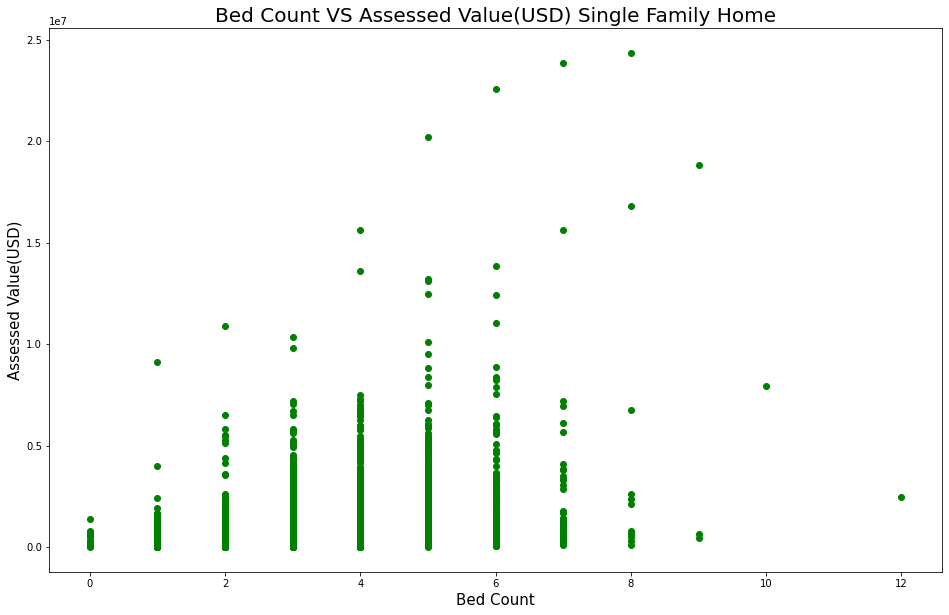

In [83]:
# Map X, and y to features of interest and check lenght


X = bed_features['bed_count']
y = bed_features['assessed_value']

plt.figure(figsize = (16, 10))
plt.scatter(X, y, color = 'green')
plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
plt.xlabel('Bed Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

> ### Bed Count VS Assessed Value (Scaled Data)*****

In [71]:
# # Create Scaled dataframes
# train_scaled, validate_scaled, test_scaled = scaled_data(train_to_scale, validate_to_scale, test_to_scale)
# # Reshape array & rename cols 
# bed_features_scaled = pd.DataFrame(np.array(train_scaled[['bed_count', 'assessed_value']].to_numpy()), columns = ['bed_count', 'assessed_value'])
# bed_features_scaled.head(3)

In [70]:
# # Map X, and y to features of interest and check lenght

# X = bed_features_scaled['bed_count']
# y = bed_features_scaled['assessed_value']

# plt.figure(figsize = (16, 10))
# plt.scatter(X, y)
# plt.title('Bed Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
# plt.xlabel('Bed Count', size = 15, color = 'black')
# plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
# plt.show()

> ### Bath Count VS Assessed Value

In [72]:
# Reshape array & rename cols 
bath_features = pd.DataFrame(np.array(train[['bath_count', 'assessed_value']].to_numpy()), columns = ['bath_count', 'assessed_value'])
bath_features.head(3)

,bath_count,assessed_value
0,2.0,64360.0
1,1.0,338073.0
2,1.0,51727.0


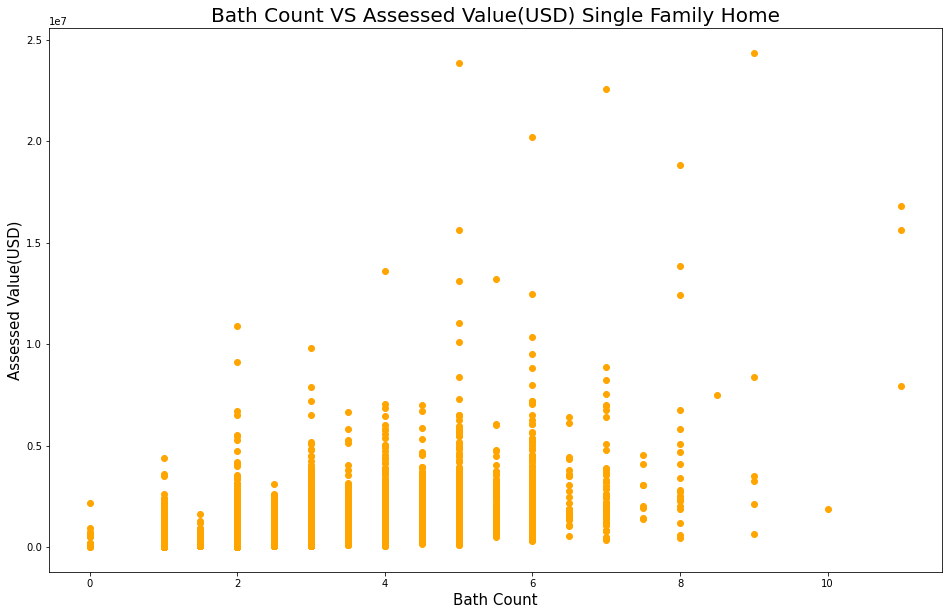

In [85]:
# Map X, and y to features of interest and check lenght

X = bath_features['bath_count']
y = bath_features['assessed_value']

plt.figure(figsize = (16, 10))
plt.scatter(X, y, color = 'orange')
plt.title('Bath Count VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
plt.xlabel('Bath Count', size = 15, color = 'black')
plt.ylabel('Assessed Value(USD)', size = 15, color = 'black')
plt.show()

> ### Square Feet VS Assessed Value

In [74]:
# Reshape array & rename cols 
square_feet_features = pd.DataFrame(np.array(train[['square_feet', 'assessed_value']].to_numpy()), columns = ['square_feet', 'assessed_value'])
square_feet_features.head(3)

,square_feet,assessed_value
0,1522.0,64360.0
1,900.0,338073.0
2,807.0,51727.0


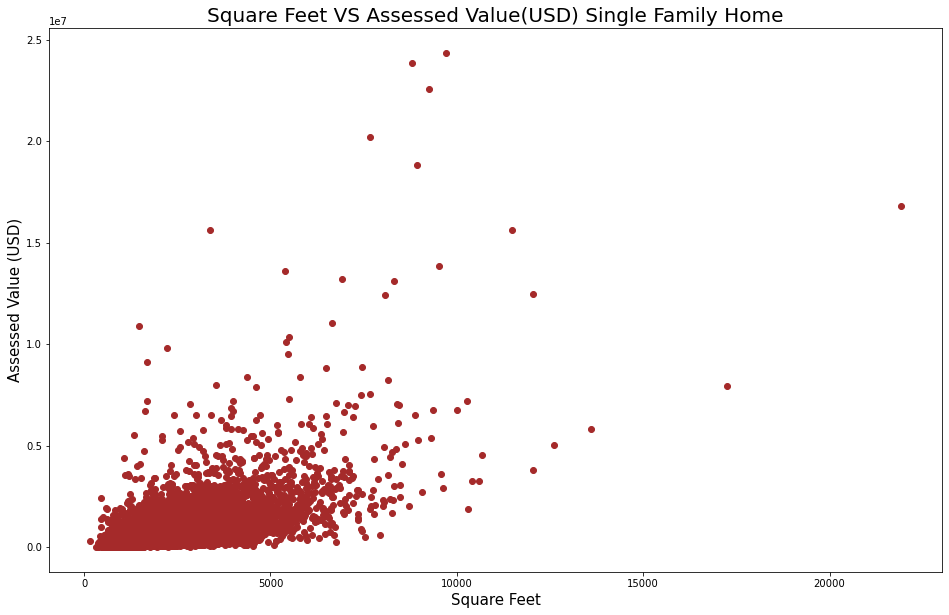

In [86]:
# Map X, and y to features of interest and check lenght

X = square_feet_features['square_feet']
y = square_feet_features['assessed_value']

plt.figure(figsize = (16, 10))
plt.scatter(X, y, color = 'brown')
plt.title('Square Feet VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
plt.xlabel('Square Feet', size = 15, color = 'black')
plt.ylabel('Assessed Value (USD)', size = 15, color = 'black')
plt.show()

> ### Transaction Month VS Assessed Value

In [77]:
# Reshape array & rename cols 
month_trans_features = pd.DataFrame(np.array(train[['trans_month', 'assessed_value']].to_numpy()), columns = ['trans_month', 'assessed_value'])
month_trans_features.head(3)

,trans_month,assessed_value
0,4.0,64360.0
1,8.0,338073.0
2,4.0,51727.0


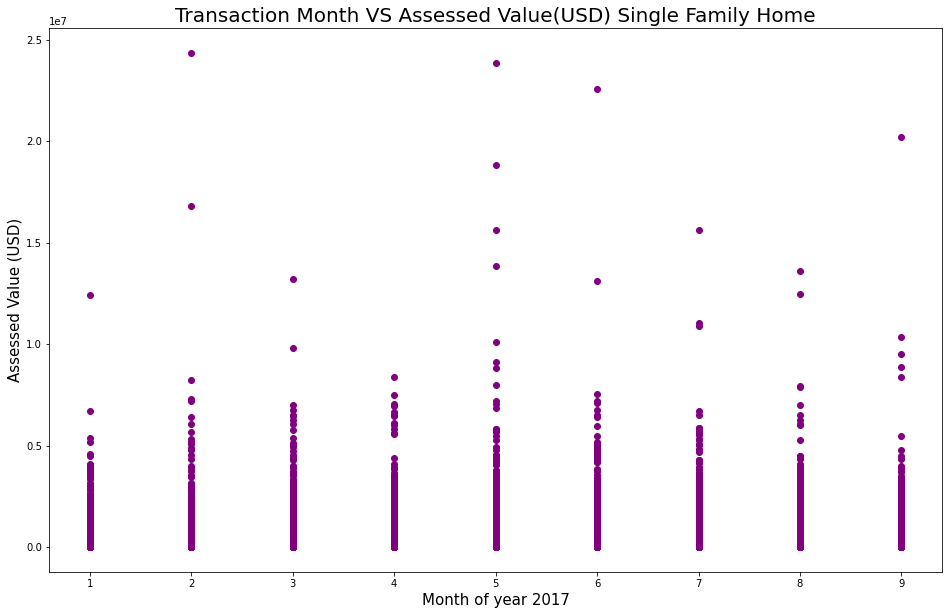

In [87]:
# Map X, and y to features of interest and check lenght

X = month_trans_features['trans_month']
y = month_trans_features['assessed_value']

plt.figure(figsize = (16, 10))
plt.scatter(X, y, color = 'purple')
plt.title('Transaction Month VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
plt.xlabel('Month of year 2017', size = 15, color = 'black')
plt.ylabel('Assessed Value (USD)', size = 15, color = 'black')
plt.show()

> ### Build Year VS Assessed Value

In [79]:
# Reshape array & rename cols 
build_year_features = pd.DataFrame(np.array(train[['built_year', 'assessed_value']].to_numpy()), columns = ['built_year', 'assessed_value'])
build_year_features.head(3)

,built_year,assessed_value
0,1925.0,64360.0
1,1951.0,338073.0
2,1951.0,51727.0


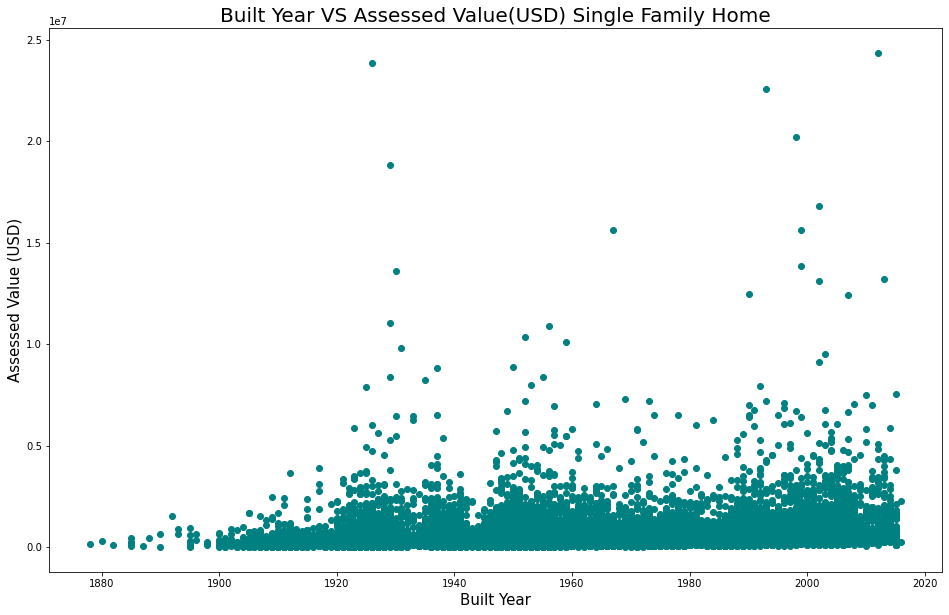

In [93]:
# Map X, and y to features of interest and check lenght

X = build_year_features['built_year']
y = build_year_features['assessed_value']

plt.figure(figsize = (16, 10))
plt.scatter(X, y, color = 'teal')
plt.title('Built Year VS Assessed Value(USD) Single Family Home', color = 'black', weight = 'normal', size = 20)
plt.xlabel('Built Year', size = 15, color = 'black')
plt.ylabel('Assessed Value (USD)', size = 15, color = 'black')
plt.show()

## Exploration Testing

# Modeling Phase: 

## Feature Engineering

## Establish Baseline

## Build Models

## Model Evaluations

## Model Selection & Testing

# Conclusions and Delivery: 